In [1]:
from __future__ import print_function

import numpy as np
import time
from keras.preprocessing.image import save_img
from keras.applications import vgg16
from keras import backend as K

# dimensions of the generated pictures for each filter.
img_width = 128
img_height = 128

# the name of the layer we want to visualize
# (see model definition at keras/applications/vgg16.py)
layer_name = 'block5_conv1'

Using TensorFlow backend.


In [2]:
# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [3]:
# build the VGG16 network with ImageNet weights
model = vgg16.VGG16(weights='imagenet', include_top=False)
print('Model loaded.')

Model loaded.


In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [5]:
# this is the placeholder for the input images
input_img = model.input

In [6]:

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])



In [7]:
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())


In [8]:
kept_filters = []
for filter_index in range(200):
    # we only scan through the first 200 filters,
    # but there are actually 512 of them
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    if K.image_data_format() == 'channels_first':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])

    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # we run gradient ascent for 20 steps
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # decode the resulting input image
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))


Processing filter 0
Current loss value: 11.760374
Current loss value: 27.9903
Current loss value: 50.911587
Current loss value: 75.3494
Current loss value: 90.981735
Current loss value: 118.82694
Current loss value: 134.47406
Current loss value: 157.83386
Current loss value: 181.36478
Current loss value: 199.57484
Current loss value: 220.35834
Current loss value: 243.07492
Current loss value: 267.5549
Current loss value: 292.06522
Current loss value: 317.71414
Current loss value: 340.59485
Current loss value: 366.84827
Current loss value: 388.7553
Current loss value: 411.024
Current loss value: 438.32864
Filter 0 processed in 3s
Processing filter 1
Current loss value: 0.16738608
Current loss value: 11.265994
Current loss value: 37.13795
Current loss value: 75.97135
Current loss value: 124.64906
Current loss value: 184.51122
Current loss value: 238.19818
Current loss value: 293.36627
Current loss value: 345.25092
Current loss value: 408.86578
Current loss value: 471.4389
Current loss va

Current loss value: 569.79443
Current loss value: 596.86066
Current loss value: 622.0818
Current loss value: 645.5951
Filter 13 processed in 3s
Processing filter 14
Current loss value: 3.951657
Current loss value: 35.68907
Current loss value: 94.732254
Current loss value: 154.28632
Current loss value: 225.64923
Current loss value: 297.43054
Current loss value: 359.57086
Current loss value: 414.93927
Current loss value: 476.90097
Current loss value: 524.7014
Current loss value: 576.5111
Current loss value: 631.10406
Current loss value: 681.4628
Current loss value: 732.5897
Current loss value: 781.6712
Current loss value: 829.1451
Current loss value: 864.75006
Current loss value: 927.09814
Current loss value: 959.5869
Current loss value: 1014.8275
Filter 14 processed in 3s
Processing filter 15
Current loss value: 0.15755673
Current loss value: 1.0733559
Current loss value: 6.7128053
Current loss value: 26.57884
Current loss value: 55.190193
Current loss value: 91.18754
Current loss value

Current loss value: 55.867626
Current loss value: 89.99435
Current loss value: 131.47713
Current loss value: 170.77042
Current loss value: 211.83362
Current loss value: 256.60223
Current loss value: 300.4362
Current loss value: 331.83914
Current loss value: 369.34457
Current loss value: 401.65808
Current loss value: 435.7395
Current loss value: 469.13776
Current loss value: 496.42566
Current loss value: 532.33997
Current loss value: 565.3276
Current loss value: 596.30115
Current loss value: 628.3015
Current loss value: 662.16614
Filter 31 processed in 3s
Processing filter 32
Current loss value: 10.803206
Current loss value: 32.615807
Current loss value: 82.48454
Current loss value: 129.9586
Current loss value: 180.16513
Current loss value: 229.45422
Current loss value: 279.12592
Current loss value: 322.5027
Current loss value: 365.13837
Current loss value: 406.7533
Current loss value: 460.9595
Current loss value: 503.82053
Current loss value: 553.501
Current loss value: 589.4132
Curren

Current loss value: 670.40393
Current loss value: 721.3933
Current loss value: 773.9546
Current loss value: 823.4568
Current loss value: 873.1797
Current loss value: 923.5752
Filter 46 processed in 3s
Processing filter 47
Current loss value: 1.4316173
Current loss value: 67.04822
Current loss value: 191.79227
Current loss value: 302.41666
Current loss value: 391.61026
Current loss value: 448.2172
Current loss value: 511.84357
Current loss value: 562.79626
Current loss value: 620.8397
Current loss value: 672.604
Current loss value: 714.2178
Current loss value: 767.1322
Current loss value: 810.6542
Current loss value: 862.4458
Current loss value: 904.14886
Current loss value: 953.1684
Current loss value: 993.2683
Current loss value: 1041.0189
Current loss value: 1086.9358
Current loss value: 1131.6162
Filter 47 processed in 3s
Processing filter 48
Current loss value: 1.6268075
Current loss value: 29.536274
Current loss value: 139.08107
Current loss value: 264.79498
Current loss value: 36

Current loss value: 379.4983
Current loss value: 423.62738
Current loss value: 473.87567
Current loss value: 525.39886
Current loss value: 576.3971
Current loss value: 618.1349
Current loss value: 671.6405
Current loss value: 716.80566
Current loss value: 759.1751
Current loss value: 809.53345
Current loss value: 854.5509
Current loss value: 902.54834
Current loss value: 944.9886
Current loss value: 993.77893
Filter 62 processed in 3s
Processing filter 63
Current loss value: 0.0
Filter 63 processed in 0s
Processing filter 64
Current loss value: 0.0
Filter 64 processed in 0s
Processing filter 65
Current loss value: 30.605858
Current loss value: 63.578186
Current loss value: 92.79007
Current loss value: 126.08508
Current loss value: 168.77594
Current loss value: 208.31357
Current loss value: 252.1922
Current loss value: 304.77463
Current loss value: 349.6819
Current loss value: 405.67993
Current loss value: 455.10498
Current loss value: 508.59735
Current loss value: 552.36566
Current los

Current loss value: 11.47101
Current loss value: 41.50581
Current loss value: 43.386967
Current loss value: 84.99256
Current loss value: 108.91597
Current loss value: 165.42667
Current loss value: 198.12636
Current loss value: 270.92313
Current loss value: 325.76526
Current loss value: 385.75507
Current loss value: 434.18573
Current loss value: 478.9516
Current loss value: 547.2223
Current loss value: 584.6366
Current loss value: 645.162
Current loss value: 673.6597
Current loss value: 732.3769
Current loss value: 770.2739
Current loss value: 824.4486
Current loss value: 867.2542
Filter 84 processed in 3s
Processing filter 85
Current loss value: 0.0
Filter 85 processed in 0s
Processing filter 86
Current loss value: 6.3965774
Current loss value: 17.54793
Current loss value: 78.792114
Current loss value: 162.5002
Current loss value: 276.97778
Current loss value: 378.3997
Current loss value: 464.08203
Current loss value: 560.3827
Current loss value: 641.7324
Current loss value: 724.5543
C

Current loss value: 41.856743
Current loss value: 100.06247
Current loss value: 164.0886
Current loss value: 246.84882
Current loss value: 327.78146
Current loss value: 405.45105
Current loss value: 479.87393
Current loss value: 569.6762
Current loss value: 642.9778
Current loss value: 712.59454
Current loss value: 790.7782
Current loss value: 857.0404
Current loss value: 922.56494
Current loss value: 1001.2584
Current loss value: 1057.0664
Current loss value: 1126.5074
Current loss value: 1185.0446
Current loss value: 1249.9498
Filter 103 processed in 3s
Processing filter 104
Current loss value: 0.0
Filter 104 processed in 0s
Processing filter 105
Current loss value: 0.0
Filter 105 processed in 0s
Processing filter 106
Current loss value: 0.0
Filter 106 processed in 0s
Processing filter 107
Current loss value: 1.789166
Current loss value: 13.218447
Current loss value: 49.92213
Current loss value: 93.95223
Current loss value: 130.41617
Current loss value: 173.10834
Current loss value: 

Current loss value: 0.1768004
Current loss value: 0.894525
Current loss value: 4.367795
Current loss value: 11.895566
Current loss value: 22.386086
Current loss value: 31.370787
Current loss value: 40.706917
Current loss value: 51.204655
Current loss value: 66.457245
Current loss value: 87.781235
Current loss value: 119.00787
Current loss value: 147.93695
Current loss value: 177.48192
Current loss value: 204.76833
Current loss value: 238.32733
Current loss value: 264.62946
Current loss value: 301.78055
Current loss value: 334.16757
Current loss value: 370.6903
Current loss value: 397.27246
Filter 123 processed in 3s
Processing filter 124
Current loss value: 0.0
Filter 124 processed in 0s
Processing filter 125
Current loss value: 0.9439454
Current loss value: 10.961683
Current loss value: 30.100748
Current loss value: 57.248924
Current loss value: 94.556625
Current loss value: 135.69345
Current loss value: 174.57867
Current loss value: 215.49887
Current loss value: 253.89426
Current los

Current loss value: 1220.2595
Current loss value: 1321.8645
Current loss value: 1413.321
Current loss value: 1513.8511
Current loss value: 1611.9639
Current loss value: 1710.258
Current loss value: 1807.5255
Current loss value: 1904.2205
Current loss value: 1999.036
Current loss value: 2093.7263
Filter 138 processed in 3s
Processing filter 139
Current loss value: 11.512235
Current loss value: 40.037647
Current loss value: 79.15251
Current loss value: 127.84096
Current loss value: 187.78885
Current loss value: 237.6546
Current loss value: 286.08484
Current loss value: 329.4425
Current loss value: 373.96667
Current loss value: 415.8893
Current loss value: 462.2488
Current loss value: 506.08038
Current loss value: 551.0064
Current loss value: 594.859
Current loss value: 635.925
Current loss value: 677.40356
Current loss value: 720.90326
Current loss value: 763.2986
Current loss value: 801.4152
Current loss value: 840.3827
Filter 139 processed in 3s
Processing filter 140
Current loss value

Current loss value: 6.948617
Current loss value: 14.465887
Current loss value: 41.823463
Current loss value: 66.93105
Current loss value: 93.5644
Current loss value: 124.96135
Current loss value: 148.85312
Current loss value: 198.8881
Current loss value: 238.52708
Current loss value: 284.8467
Current loss value: 328.23688
Current loss value: 368.34363
Current loss value: 410.16302
Current loss value: 452.3801
Current loss value: 502.2564
Current loss value: 544.3412
Current loss value: 585.947
Current loss value: 625.57666
Filter 153 processed in 3s
Processing filter 154
Current loss value: 21.129028
Current loss value: 78.43738
Current loss value: 142.06143
Current loss value: 205.08392
Current loss value: 267.6526
Current loss value: 316.02954
Current loss value: 378.22662
Current loss value: 435.50327
Current loss value: 495.73984
Current loss value: 551.09204
Current loss value: 603.1676
Current loss value: 650.1735
Current loss value: 707.0899
Current loss value: 757.5498
Current 

Current loss value: 577.90356
Current loss value: 622.99023
Current loss value: 667.648
Current loss value: 708.4363
Current loss value: 750.5284
Current loss value: 790.99915
Current loss value: 832.6347
Current loss value: 872.38696
Filter 168 processed in 3s
Processing filter 169
Current loss value: 0.0
Filter 169 processed in 0s
Processing filter 170
Current loss value: 16.31956
Current loss value: 30.355762
Current loss value: 65.10273
Current loss value: 94.940674
Current loss value: 142.77322
Current loss value: 191.25778
Current loss value: 247.06158
Current loss value: 291.466
Current loss value: 338.38742
Current loss value: 392.11865
Current loss value: 441.05777
Current loss value: 490.84152
Current loss value: 541.23096
Current loss value: 593.5048
Current loss value: 638.3058
Current loss value: 690.39514
Current loss value: 738.2396
Current loss value: 787.25134
Current loss value: 832.8279
Current loss value: 883.54956
Filter 170 processed in 3s
Processing filter 171
Cu

Current loss value: 617.83264
Current loss value: 649.38293
Filter 185 processed in 3s
Processing filter 186
Current loss value: 1.1688842
Current loss value: 12.488585
Current loss value: 50.669518
Current loss value: 96.09041
Current loss value: 134.74689
Current loss value: 177.72241
Current loss value: 220.89804
Current loss value: 257.25946
Current loss value: 302.2757
Current loss value: 345.90955
Current loss value: 387.1653
Current loss value: 430.2619
Current loss value: 486.03644
Current loss value: 529.7179
Current loss value: 573.98193
Current loss value: 618.0106
Current loss value: 659.9873
Current loss value: 700.52637
Current loss value: 743.7469
Current loss value: 779.9158
Filter 186 processed in 3s
Processing filter 187
Current loss value: 11.483372
Current loss value: 65.50425
Current loss value: 185.15851
Current loss value: 311.04645
Current loss value: 426.46503
Current loss value: 531.2268
Current loss value: 630.2848
Current loss value: 721.80554
Current loss v

In [9]:
# we will stich the best 64 filters on a 8 x 8 grid.
n = 8

# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top 64 filters.
kept_filters.sort(key=lambda x: x[1], reverse=True)
kept_filters = kept_filters[:n * n]


In [10]:
# build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))


In [11]:
# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                         (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img


In [12]:
# save the result to disk
save_img('stitched_filters_%dx%d.png' % (n, n), stitched_filters)

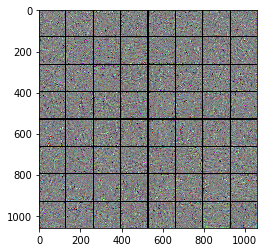

In [13]:
%matplotlib inline
from matplotlib.pyplot import imshow

imshow(stitched_filters)